# Synchronous dvantage actor crtic

This notebook is here to reproduce the TD3 of the course, to ensure that our project organization is viable. Moreover we will use this structure as a baseline for our re-implementation of DDPG.

## Imports

The above imports are not at all mandatory in order to have the following code work. This cell is here to ensure that your setup is correct. 

In [3]:
%cd ..


/home/arthur/drl/mva-drl-project


In [8]:
#@title Imports  { form-width: "30%" }

%matplotlib inline
# import IPython
# from IPython.display import HTML
# from IPython import display as ipythondisplay

import acme
from acme import datasets
from acme import types
from acme import specs
from acme.wrappers import gym_wrapper
import base64
from base64 import b64encode
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import imageio
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import multiprocessing as mp
import multiprocessing.connection
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time
import tree
from typing import *
import warnings
import pyglet
pyglet.options['search_local_libs'] = False
pyglet.options['shadow_window']=False
from pyglet.window import xlib
xlib._have_utf8 = False

from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
display.start()
 
np.set_printoptions(precision=3, suppress=1)
%matplotlib inline

## Random Agent on pendulum 


In [6]:
import acme

from src.environments.inverted_pendulum import InvertedPendulumEnv
from src.agents import RandomAgent
from src.interaction_loops import simple_interaction_loop
from src.plot_utils import display_video

In [9]:
pendulum_environment = InvertedPendulumEnv(for_evaluation=True)  #### WARNING, I changed the env
pendulum_environment_spec = acme.make_environment_spec(pendulum_environment)
pendulum_random_agent = RandomAgent(pendulum_environment_spec)

simple_interaction_loop(pendulum_random_agent, pendulum_environment, 5000)

In [10]:
display_video(np.stack(pendulum_environment.screens, axis=0))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7209780] Warning: data is not aligned! This can lead to a speed loss


## A2C agent

In [14]:
# import A2C specific
from src.agents import A2CAgent
from src.environments.inverted_pendulum import inverted_pendulum_env_factory
from src.interaction_loops import a2c_parallel_interaction_loop, evaluation_parallel_interaction_loop
from src.plot_utils import plot_policy_on_pendulum

In [15]:
# define the agent
num_evaluation_steps = 1000
max_learner_steps=50
sequence_length=4
pendulum_agent = A2CAgent(seed=0, 
learning_rate=5e-4,
 gamma=.95,
  value_output_sizes=[256, 256],
   policy_output_sizes=[256, 256], 
   environment_spec=pendulum_environment_spec, 
   entropy_loss_coef=3e-1)

actions_mean: 0.10	|entropy_loss: 1.06	|mean_reward: -2.66	|obs: 0.19, 0.18, 0.28	|policy_loss: 6.31	|value_loss: 32.60	|value_mean: 0.66	|value_target_mean: -5.02
actions_mean: -0.06	|entropy_loss: 0.36	|mean_reward: -5.97	|obs: -0.29, 0.14, -0.95	|policy_loss: 3.18	|value_loss: 102.80	|value_mean: -3.99	|value_target_mean: -15.55
actions_mean: -0.33	|entropy_loss: 0.84	|mean_reward: -5.92	|obs: -0.39, 0.08, -0.23	|policy_loss: 7.24	|value_loss: 96.27	|value_mean: -6.94	|value_target_mean: -18.17
actions_mean: -0.59	|entropy_loss: 1.16	|mean_reward: -7.54	|obs: -0.61, 0.18, -0.80	|policy_loss: 15.70	|value_loss: 120.56	|value_mean: -8.97	|value_target_mean: -22.30
actions_mean: -0.79	|entropy_loss: 0.96	|mean_reward: -7.83	|obs: -0.71, 0.07, -1.12	|policy_loss: 13.04	|value_loss: 127.91	|value_mean: -10.41	|value_target_mean: -24.53


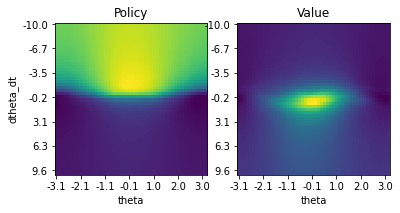

Average return: -1321.0103052798754
actions_mean: -0.78	|entropy_loss: 1.78	|mean_reward: -3.53	|obs: 0.06, 0.12, 0.03	|policy_loss: 15.80	|value_loss: 48.11	|value_mean: -10.66	|value_target_mean: -16.77
actions_mean: -0.97	|entropy_loss: 1.93	|mean_reward: -7.72	|obs: -0.65, -0.05, -1.02	|policy_loss: 19.39	|value_loss: 144.24	|value_mean: -12.37	|value_target_mean: -27.19
actions_mean: -1.15	|entropy_loss: 3.21	|mean_reward: -7.33	|obs: -0.63, 0.01, 0.31	|policy_loss: 20.12	|value_loss: 112.74	|value_mean: -13.24	|value_target_mean: -26.29
actions_mean: -1.29	|entropy_loss: 4.73	|mean_reward: -6.71	|obs: -0.49, 0.14, -0.50	|policy_loss: -159.64	|value_loss: 107.71	|value_mean: -13.90	|value_target_mean: -25.95
actions_mean: -1.46	|entropy_loss: 6.12	|mean_reward: -7.82	|obs: -0.59, 0.34, -1.82	|policy_loss: -2865.58	|value_loss: 134.25	|value_mean: -14.90	|value_target_mean: -28.67


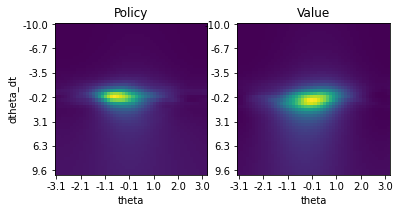

Average return: -1469.864527214824
actions_mean: -1.59	|entropy_loss: 7.43	|mean_reward: -3.49	|obs: -0.06, -0.08, -0.12	|policy_loss: 45.56	|value_loss: 33.89	|value_mean: -15.13	|value_target_mean: -20.82
actions_mean: -1.75	|entropy_loss: 8.79	|mean_reward: -7.49	|obs: -0.48, -0.06, -2.65	|policy_loss: -630467.12	|value_loss: 129.94	|value_mean: -16.61	|value_target_mean: -30.16
actions_mean: -1.92	|entropy_loss: 10.31	|mean_reward: -8.60	|obs: -0.51, 0.23, -2.72	|policy_loss: -16714683.00	|value_loss: 145.44	|value_mean: -17.49	|value_target_mean: -31.89
actions_mean: -2.09	|entropy_loss: 11.87	|mean_reward: -6.60	|obs: -0.15, 0.26, -2.77	|policy_loss: -358845792.00	|value_loss: 85.46	|value_mean: -18.37	|value_target_mean: -29.43
actions_mean: -2.26	|entropy_loss: 13.46	|mean_reward: -7.08	|obs: -0.25, 0.10, -3.66	|policy_loss: -10052864000.00	|value_loss: 120.39	|value_mean: -19.22	|value_target_mean: -31.49


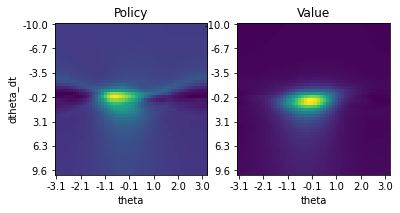

Average return: -1362.4746171284894
actions_mean: -2.45	|entropy_loss: 15.44	|mean_reward: -4.40	|obs: -0.27, 0.08, -0.31	|policy_loss: -15.06	|value_loss: 45.67	|value_mean: -19.95	|value_target_mean: -27.14
actions_mean: -2.64	|entropy_loss: 17.21	|mean_reward: -5.51	|obs: -0.24, 0.18, -1.32	|policy_loss: -16264952020992.00	|value_loss: 63.57	|value_mean: -21.07	|value_target_mean: -30.10
actions_mean: -2.85	|entropy_loss: 19.27	|mean_reward: -7.56	|obs: -0.55, 0.17, -1.57	|policy_loss: -1460512487374848.00	|value_loss: 124.33	|value_mean: -21.98	|value_target_mean: -34.80
actions_mean: -3.07	|entropy_loss: 21.27	|mean_reward: -6.75	|obs: -0.46, 0.59, -1.57	|policy_loss: -74486458173358080.00	|value_loss: 76.50	|value_mean: -22.90	|value_target_mean: -32.89
actions_mean: -3.26	|entropy_loss: 23.03	|mean_reward: -5.08	|obs: -0.14, 0.53, -1.51	|policy_loss: -459588095109496832.00	|value_loss: 50.15	|value_mean: -23.82	|value_target_mean: -31.39


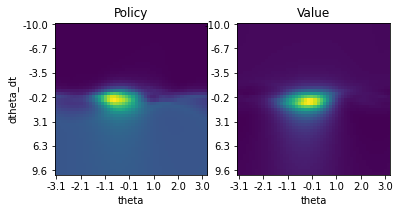

Average return: -1380.6662785113458
actions_mean: -3.30	|entropy_loss: 25.32	|mean_reward: -4.88	|obs: -0.41, -0.26, -0.86	|policy_loss: -84076412928.00	|value_loss: 43.66	|value_mean: -24.69	|value_target_mean: -32.54
actions_mean: -3.10	|entropy_loss: 24.34	|mean_reward: -8.32	|obs: -0.51, -0.04, -3.42	|policy_loss: -82631043208389328896.00	|value_loss: 152.60	|value_mean: -25.73	|value_target_mean: -40.49
actions_mean: -2.85	|entropy_loss: 22.39	|mean_reward: -8.36	|obs: -0.54, 0.31, -3.49	|policy_loss: -3152963941856968704.00	|value_loss: 118.11	|value_mean: -26.78	|value_target_mean: -39.94
actions_mean: -2.68	|entropy_loss: 21.47	|mean_reward: -6.75	|obs: -0.20, 0.19, -3.35	|policy_loss: -152798340638048256.00	|value_loss: 71.99	|value_mean: -27.86	|value_target_mean: -38.20
actions_mean: -2.64	|entropy_loss: 21.33	|mean_reward: -8.08	|obs: -0.47, -0.03, -3.78	|policy_loss: -11371199720325120.00	|value_loss: 136.93	|value_mean: -28.96	|value_target_mean: -42.77


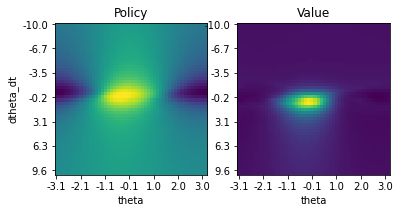

Average return: -1440.0964049727231
actions_mean: -2.46	|entropy_loss: 21.17	|mean_reward: -3.77	|obs: -0.04, 0.09, -0.37	|policy_loss: -92406992.00	|value_loss: 36.39	|value_mean: -29.68	|value_target_mean: -34.63
actions_mean: -2.51	|entropy_loss: 20.85	|mean_reward: -6.52	|obs: -0.19, 0.37, -3.23	|policy_loss: -102721457750016.00	|value_loss: 77.18	|value_mean: -31.11	|value_target_mean: -40.90
actions_mean: -2.54	|entropy_loss: 21.00	|mean_reward: -7.52	|obs: -0.38, 0.17, -3.18	|policy_loss: -18085511692288.00	|value_loss: 94.03	|value_mean: -32.24	|value_target_mean: -43.92
actions_mean: -2.53	|entropy_loss: 21.08	|mean_reward: -8.02	|obs: -0.44, 0.36, -2.68	|policy_loss: -4908804734976.00	|value_loss: 107.92	|value_mean: -33.38	|value_target_mean: -45.35
actions_mean: -2.49	|entropy_loss: 20.94	|mean_reward: -6.93	|obs: -0.26, 0.19, -2.92	|policy_loss: -568610062336.00	|value_loss: 76.74	|value_mean: -34.45	|value_target_mean: -44.57


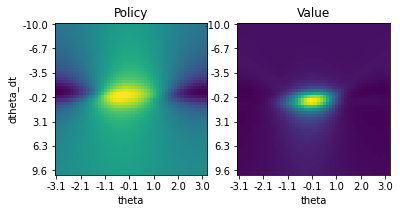

Average return: -1356.7791274532892
actions_mean: -2.38	|entropy_loss: 20.89	|mean_reward: -3.21	|obs: 0.08, -0.21, -0.70	|policy_loss: -46714008.00	|value_loss: 23.92	|value_mean: -34.91	|value_target_mean: -38.50
actions_mean: -2.50	|entropy_loss: 20.75	|mean_reward: -8.12	|obs: -0.33, -0.18, -4.69	|policy_loss: -10826226688.00	|value_loss: 128.84	|value_mean: -36.79	|value_target_mean: -50.07
actions_mean: -2.52	|entropy_loss: 20.85	|mean_reward: -9.12	|obs: -0.52, 0.38, -4.66	|policy_loss: -1950618880.00	|value_loss: 114.46	|value_mean: -37.94	|value_target_mean: -50.93
actions_mean: -2.45	|entropy_loss: 20.63	|mean_reward: -6.27	|obs: 0.11, 0.35, -3.41	|policy_loss: -260858544.00	|value_loss: 54.96	|value_mean: -39.12	|value_target_mean: -47.40
actions_mean: -2.48	|entropy_loss: 20.79	|mean_reward: -7.63	|obs: -0.17, -0.11, -4.21	|policy_loss: -76016488.00	|value_loss: 112.38	|value_mean: -40.18	|value_target_mean: -52.61


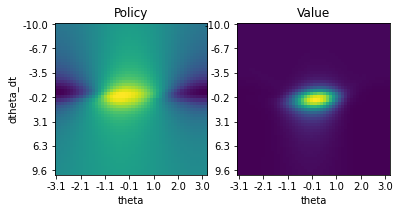

Average return: -1299.3353001247017
actions_mean: -2.47	|entropy_loss: 21.26	|mean_reward: -3.56	|obs: -0.05, 0.16, -0.28	|policy_loss: -86189464.00	|value_loss: 22.03	|value_mean: -39.65	|value_target_mean: -43.80
actions_mean: -2.51	|entropy_loss: 21.08	|mean_reward: -6.77	|obs: -0.36, 0.40, -1.92	|policy_loss: -56334864.00	|value_loss: 83.22	|value_mean: -42.76	|value_target_mean: -52.45
actions_mean: -2.49	|entropy_loss: 21.00	|mean_reward: -6.60	|obs: -0.28, 0.55, -2.14	|policy_loss: -14059961.00	|value_loss: 63.48	|value_mean: -42.63	|value_target_mean: -51.60
actions_mean: -2.46	|entropy_loss: 20.82	|mean_reward: -6.24	|obs: -0.14, 0.28, -2.02	|policy_loss: -10104040.00	|value_loss: 59.61	|value_mean: -44.89	|value_target_mean: -53.20
actions_mean: -2.52	|entropy_loss: 21.08	|mean_reward: -8.17	|obs: -0.52, -0.00, -2.45	|policy_loss: -10889502.00	|value_loss: 109.48	|value_mean: -46.17	|value_target_mean: -58.47


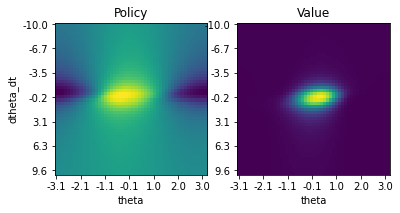

Average return: -1311.5719493250374
actions_mean: -2.38	|entropy_loss: 20.89	|mean_reward: -3.14	|obs: 0.08, -0.10, -0.69	|policy_loss: -12099364.00	|value_loss: 21.82	|value_mean: -41.49	|value_target_mean: -45.50
actions_mean: -2.49	|entropy_loss: 20.78	|mean_reward: -7.67	|obs: -0.22, 0.04, -4.00	|policy_loss: -34035928.00	|value_loss: 98.42	|value_mean: -48.85	|value_target_mean: -59.80
actions_mean: -2.50	|entropy_loss: 20.89	|mean_reward: -8.02	|obs: -0.37, 0.34, -3.85	|policy_loss: -18140246.00	|value_loss: 80.75	|value_mean: -50.15	|value_target_mean: -60.38
actions_mean: -2.44	|entropy_loss: 20.73	|mean_reward: -5.94	|obs: 0.07, 0.41, -3.33	|policy_loss: -21133958.00	|value_loss: 47.73	|value_mean: -50.76	|value_target_mean: -57.45
actions_mean: -2.44	|entropy_loss: 20.66	|mean_reward: -6.85	|obs: -0.09, 0.01, -3.99	|policy_loss: -8343014.00	|value_loss: 76.85	|value_mean: -51.34	|value_target_mean: -60.32


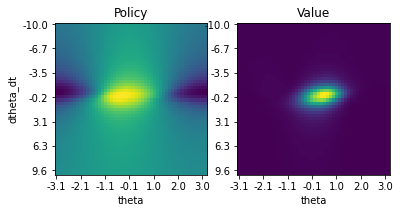

Average return: -1479.2232696721449
actions_mean: -2.52	|entropy_loss: 21.44	|mean_reward: -4.54	|obs: -0.27, -0.03, -0.47	|policy_loss: -177985344.00	|value_loss: 25.99	|value_mean: -52.08	|value_target_mean: -56.85
actions_mean: -2.55	|entropy_loss: 21.19	|mean_reward: -8.01	|obs: -0.49, 0.15, -2.39	|policy_loss: -27556672.00	|value_loss: 94.77	|value_mean: -55.50	|value_target_mean: -66.23
actions_mean: -2.55	|entropy_loss: 21.14	|mean_reward: -7.53	|obs: -0.47, 0.49, -2.40	|policy_loss: -11038268.00	|value_loss: 62.98	|value_mean: -56.84	|value_target_mean: -65.71
actions_mean: -2.54	|entropy_loss: 21.22	|mean_reward: -6.11	|obs: -0.17, 0.39, -2.23	|policy_loss: -27002102.00	|value_loss: 36.24	|value_mean: -57.63	|value_target_mean: -64.16
actions_mean: -2.53	|entropy_loss: 21.12	|mean_reward: -7.37	|obs: -0.39, 0.18, -2.44	|policy_loss: -46532288.00	|value_loss: 86.41	|value_mean: -59.08	|value_target_mean: -68.00


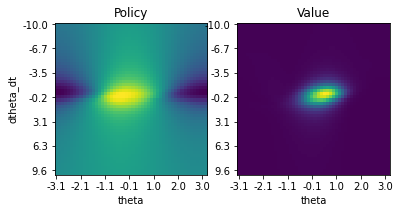

Average return: -1570.6509805339479


In [17]:
for _ in range(10):
  a2c_parallel_interaction_loop(pendulum_agent, env_factory=inverted_pendulum_env_factory, max_learner_steps=max_learner_steps, sequence_length=sequence_length, num_actors=16)
  plot_policy_on_pendulum(pendulum_agent, 50)
  evaluation_parallel_interaction_loop(pendulum_agent, env_factory=inverted_pendulum_env_factory, sequence_length=200, num_actors=4)